# Logistic Regression
Necessary imports and plot functions used over the entire python notebook:

In [1]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from math import log

In [2]:
# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
IMAGES_PATH = "./images"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
data = scipy.io.loadmat('spamData.mat')
Xtrain, Xtest, ytrain, ytest = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']

## Pre-processing

In [4]:
eps = np.finfo(float).eps

def log_elem(x):
    return log(x + 0.1)
def binarize_elem(x):
    return 1 if x > eps else 0

def preprocess(X, method="z-norm", mean=None, std=None):
    if method=="z-norm":
        from scipy.stats import zscore
        return zscore(X, axis=0, ddof=1)
    elif method == "log-transform":
        npLog = np.vectorize(log_elem)
        return npLog(X)
    elif method == "binarization":
        npBinarize = np.vectorize(binarize_elem)
        return npBinarize(X)
    else:
        print("Undefined preprocessing option")

In [5]:
Xtrain = preprocess(Xtrain, "z-norm")
Xtest = preprocess(Xtest, "z-norm")
Xtrain = np.c_[np.ones(Xtrain.shape[0]),Xtrain] #add bias term
Xtest = np.c_[np.ones(Xtest.shape[0]),Xtest] #add bias term

## Logistic Regression

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
w = np.zeros(Xtrain.shape[1]) #initialize with zeros
reg_lambda = np.r_[1:10, 10:105:5]
print(w.shape)
mu = sigmoid(np.dot(Xtrain, w))
mu = np.reshape(mu, (-1,1))
print(mu.shape)

(58,)
(3065, 1)


In [8]:
def loss(X, y, w, reg):
    neg_loss = 0
    eps = np.finfo(float).eps
    for i in range(X.shape[0]):
        mu = sigmoid(np.dot(X[i], w))
        neg_loss += y[i]*log(max(mu, eps)) + (1-y[i])*log(max(1-mu,eps))
    return -neg_loss + reg*np.dot(w[1:].T,w[1:])

In [9]:
reg = 1
g = np.dot(Xtrain.T, (mu - ytrain)) + np.reshape(reg*np.concatenate(([0],w[1:])),(-1,1))
print(g.shape)
S = np.diag((mu.ravel()*(1-mu.ravel())))
H = np.linalg.multi_dot([Xtrain.T, S, Xtrain]) + reg*np.diag(np.concatenate(([0],np.ones(len(w[1:])))))
print(H.shape)

(58, 1)
(58, 58)


In [10]:
eps = 1e-5
i=0
H_reg = reg*np.diag(np.concatenate(([0],np.ones(len(w[1:])))))
w_old = w-10*eps
reg = 1
while(abs(w - w_old).any()>eps): #until convergence
    mu = sigmoid(np.dot(Xtrain, w.ravel()))
    mu = np.resize(mu, (mu.shape[0],1))
    g = np.dot(Xtrain.T, (mu - ytrain))  + np.reshape(reg*np.concatenate(([0],w[1:])),(-1,1))
    S = np.diag((mu.ravel()*(1-mu.ravel())))
    H = np.linalg.multi_dot([Xtrain.T, S, Xtrain]) + H_reg
    d = np.linalg.solve(H, -g)
    w_old = w
    w += d.ravel()
print(loss(Xtrain, ytrain, w, 1))
print(w)

[1069.82909513]
[-0.39216966 -0.07442543 -0.06157563  0.08691911  0.07852012  0.20992318
  0.15755507  0.33533308  0.16601904  0.05141486  0.07905788  0.03276929
 -0.09742172  0.004802    0.00681521  0.01947748  0.2414747   0.0641206
  0.12740917  0.12353471  0.11899697  0.30416704  0.19138269  0.22756743
  0.1840256  -0.14666916 -0.09109311 -0.1474789  -0.01091469 -0.02057913
 -0.08406719 -0.07058219  0.05053937 -0.10030217  0.02829378 -0.05752127
  0.08061407 -0.04041146 -0.02591308 -0.02707596  0.0542251  -0.02212377
 -0.09275699 -0.06467047 -0.06910605 -0.14282992 -0.13060205 -0.03553861
 -0.06786748 -0.15107607 -0.03245226 -0.0358232   0.18416611  0.23447171
  0.04907803  0.03384243  0.02508223  0.19400261]


## Custom Logistic Regression Class for future use

In [11]:
from math import log
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

eps = np.finfo(float).eps

class LogisticRegression(BaseEstimator, TransformerMixin):
    def __init__(self, preprocess="z-norm", alpha=0, threshold=0.5):
        self.preprocess = preprocess
        self.alpha = alpha  #regularization parameter
        self.threshold = threshold  #decision threshold
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def loss(self, X, y):
        neg_loss = 0
        eps = np.finfo(float).eps
        for i in range(X.shape[0]):
            mu = sigmoid(np.dot(X[i], self.w))
            neg_loss += y[i]*log(max(mu, eps)) + (1-y[i])*log(max(1-mu,eps))
        return -neg_loss + self.alpha*np.dot(w[1:].T,w[1:])
    
    def fit(self, X, y):
        X = preprocess(X, self.preprocess)
        X = np.c_[np.ones(X.shape[0]),X] #add bias term
        self.w = np.zeros(X.shape[1]) #initialize parameters with zeros
        convergence_limit = 1e-5
        H_reg = self.alpha*np.diag(np.concatenate(([0],np.ones(len(self.w[1:])))))
        w_old = self.w-10*convergence_limit
        reg = 1
        while(abs(self.w - w_old).any()>convergence_limit): #until convergence
            mu = self.sigmoid(np.dot(X, self.w.ravel()))
            mu = np.resize(mu, (mu.shape[0],1))
            g = np.dot(X.T, (mu - y))  + np.reshape(self.alpha*np.concatenate(([0],self.w[1:])),(-1,1))
            S = np.diag((mu.ravel()*(1-mu.ravel())))
            H = np.linalg.multi_dot([X.T, S, X]) + H_reg
            d = np.linalg.solve(H, -g)
            w_old = self.w
            self.w += d.ravel()
        return self
    
    def decision(self, X):
        X = preprocess(X, self.preprocess)
        X = np.c_[np.ones(X.shape[0]),X] #add bias term
        pestimate = []
        for x in X:
            pestimate.append(self.sigmoid(np.dot(x,self.w)))
        return pestimate
    
    def transform(self, X):
        X = preprocess(X, self.preprocess)
        X = np.c_[np.ones(X.shape[0]),X] #add bias term
        ytilde = []
        for x in X:
            ytilde.append(1 if self.sigmoid(np.dot(x,self.w))>=self.threshold else 0)
        return ytilde

## Preprocessing: Z-normalization

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

error_rate_test = []
for l in reg_lambda:
    data = scipy.io.loadmat('spamData.mat')
    Xtrain, Xtest, ytrain, ytest = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
    logReg = LogisticRegression(preprocess="z-norm", alpha=l)
    logReg.fit(Xtrain, ytrain)
    ytilde = logReg.transform(Xtest)
    error_rate_test.append(1-accuracy_score(ytest, ytilde, normalize=True))

In [13]:
error_rate_train = []
for l in reg_lambda:
    data = scipy.io.loadmat('spamData.mat')
    Xtrain, Xtest, ytrain, ytest = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
    logReg = LogisticRegression(preprocess="z-norm", alpha=l)
    logReg.fit(Xtrain, ytrain)
    ytilde = logReg.transform(Xtrain)
    error_rate_train.append(1-accuracy_score(ytrain, ytilde, normalize=True))

Saving figure Q3_1_alpha_vs_errorRate_test
Train Error rate for alpha = 1: 0.10407830342577484
Train Error rate for alpha = 10: 0.10375203915171294
Train Error rate for alpha = 100: 0.10636215334420884
Test Error rate for alpha = 1: 0.12955729166666663
Test Error rate for alpha = 10: 0.12955729166666663
Test Error rate for alpha = 100: 0.12760416666666663


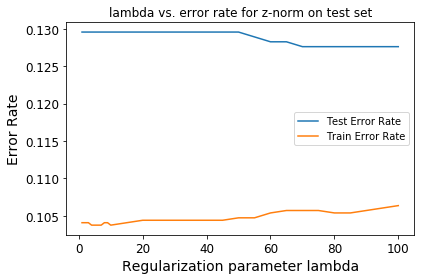

In [15]:
plt.plot(reg_lambda, error_rate_test, label="Test Error Rate")
plt.plot(reg_lambda, error_rate_train, label="Train Error Rate")
plt.title("lambda vs. error rate for z-norm on test set")
plt.xlabel("Regularization parameter lambda")
plt.ylabel("Error Rate")
plt.legend()
save_fig("Q3_1_alpha_vs_errorRate_test")
print("Train Error rate for alpha = 1: " + str(error_rate_train[0]))
print("Train Error rate for alpha = 10: " + str(error_rate_train[9]))
print("Train Error rate for alpha = 100: " + str(error_rate_train[-1]))
print("Test Error rate for alpha = 1: " + str(error_rate_test[0]))
print("Test Error rate for alpha = 10: " + str(error_rate_test[9]))
print("Test Error rate for alpha = 100: " + str(error_rate_test[-1]))

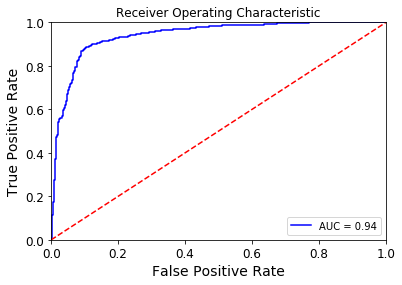

Saving figure Q3_3_ROC_curve


<Figure size 432x288 with 0 Axes>

In [16]:
data = scipy.io.loadmat('spamData.mat')
Xtrain, Xtest, ytrain, ytest = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
logReg = LogisticRegression(preprocess="z-norm", alpha=100)
logReg.fit(Xtrain, ytrain)
ytilde = logReg.transform(Xtest)
pestimate = logReg.decision(Xtest)

fpr, tpr, thresholds = roc_curve(ytest, pestimate, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
save_fig("Q3_3_ROC_curve")

Saving figure Q3_4_precision_recall_vs_threshold_plot


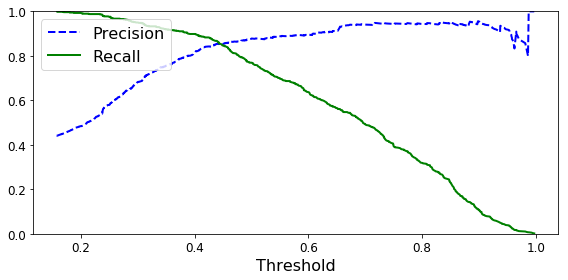

Optimal threshold is: 0.21163462824667734


In [19]:
precisions, recalls, thresholds = precision_recall_curve(ytest, pestimate)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.xlim([-60, -10])
save_fig("Q3_4_precision_recall_vs_threshold_plot")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold is: " + str(optimal_threshold))

Saving figure Q3_5_precision_vs_recall_plot


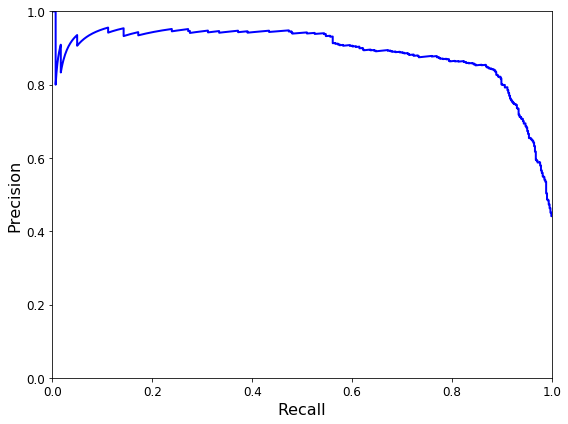

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("Q3_5_precision_vs_recall_plot")
plt.show()

## Preprocessing: Log transform

Saving figure Q3_6_alpha_vs_errorRate
Train Error rate for alpha = 1: 0.05872756933115819
Train Error rate for alpha = 10: 0.05905383360522021
Train Error rate for alpha = 100: 0.06460032626427403
Test Error rate for alpha = 1: 0.06966145833333337
Test Error rate for alpha = 10: 0.0703125
Test Error rate for alpha = 100: 0.07291666666666663


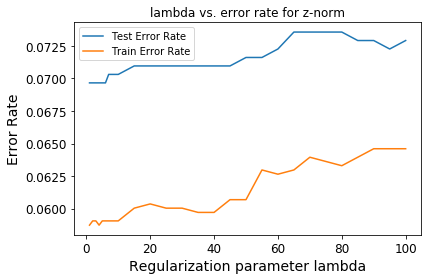

In [16]:
error_rate_test = []
for l in reg_lambda:
    data = scipy.io.loadmat('spamData.mat')
    Xtrain, Xtest, ytrain, ytest = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
    logReg = LogisticRegression(preprocess="log-transform", alpha=l)
    logReg.fit(Xtrain, ytrain)
    ytilde = logReg.transform(Xtest)
    error_rate_test.append(1-accuracy_score(ytest, ytilde, normalize=True))
    
error_rate_train = []
for l in reg_lambda:
    data = scipy.io.loadmat('spamData.mat')
    Xtrain, Xtest, ytrain, ytest = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
    logReg = LogisticRegression(preprocess="log-transform", alpha=l)
    logReg.fit(Xtrain, ytrain)
    ytilde = logReg.transform(Xtrain)
    error_rate_train.append(1-accuracy_score(ytrain, ytilde, normalize=True))
    
plt.plot(reg_lambda, error_rate_test, label="Test Error Rate")
plt.plot(reg_lambda, error_rate_train, label="Train Error Rate")
plt.title("lambda vs. error rate for z-norm")
plt.xlabel("Regularization parameter lambda")
plt.ylabel("Error Rate")
plt.legend()
save_fig("Q3_6_alpha_vs_errorRate")
print("Train Error rate for alpha = 1: " + str(error_rate_train[0]))
print("Train Error rate for alpha = 10: " + str(error_rate_train[9]))
print("Train Error rate for alpha = 100: " + str(error_rate_train[-1]))
print("Test Error rate for alpha = 1: " + str(error_rate_test[0]))
print("Test Error rate for alpha = 10: " + str(error_rate_test[9]))
print("Test Error rate for alpha = 100: " + str(error_rate_test[-1]))

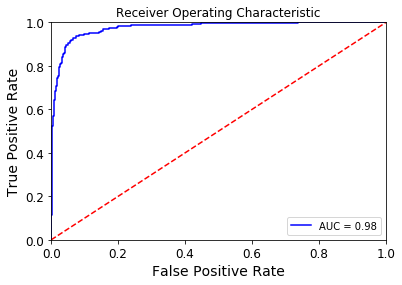

Saving figure Q3_8_ROC_curve


<Figure size 432x288 with 0 Axes>

In [26]:
data = scipy.io.loadmat('spamData.mat')
Xtrain, Xtest, ytrain, ytest = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
logReg = LogisticRegression(preprocess="log-transform", alpha=1)
logReg.fit(Xtrain, ytrain)
ytilde = logReg.transform(Xtest)
pestimate = logReg.decision(Xtest)
fpr, tpr, thresholds = roc_curve(ytest, pestimate, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
save_fig("Q3_8_ROC_curve")

Saving figure Q3_9_precision_recall_vs_threshold_plot_log


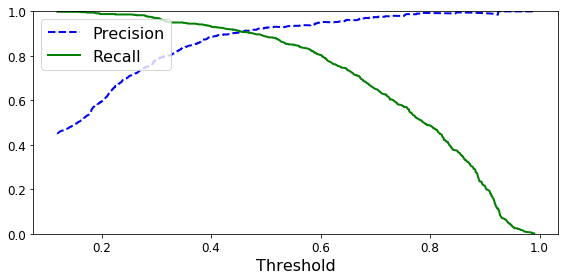

Optimal threshold is: 0.15701479166704616


In [27]:
precisions, recalls, thresholds = precision_recall_curve(ytest, pestimate)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.xlim([-60, -10])
save_fig("Q3_9_precision_recall_vs_threshold_plot_log")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold is: " + str(optimal_threshold))

Saving figure Q3_10_precision_vs_recall_plot_log


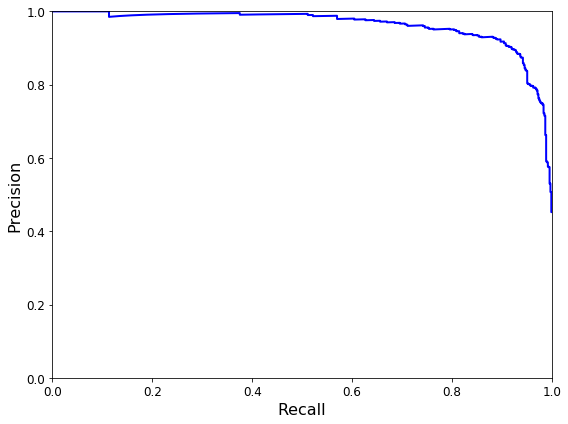

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("Q3_10_precision_vs_recall_plot_log")
plt.show()

## Pre-processing: Binarization

Saving figure Q3_11_alpha_vs_errorRate_binary
Train Error rate for alpha = 1: 0.07177814029363783
Train Error rate for alpha = 10: 0.07504078303425776
Train Error rate for alpha = 100: 0.09265905383360518
Test Error rate for alpha = 1: 0.08138020833333337
Test Error rate for alpha = 10: 0.08528645833333337
Test Error rate for alpha = 100: 0.09895833333333337


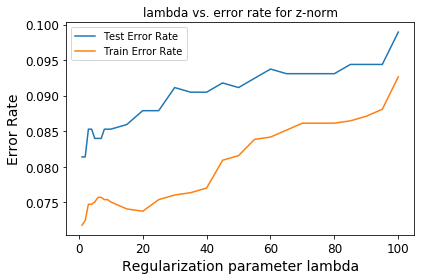

In [17]:
error_rate_test = []
for l in reg_lambda:
    data = scipy.io.loadmat('spamData.mat')
    Xtrain, Xtest, ytrain, ytest = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
    logReg = LogisticRegression(preprocess="binarization", alpha=l)
    logReg.fit(Xtrain, ytrain)
    ytilde = logReg.transform(Xtest)
    error_rate_test.append(1-accuracy_score(ytest, ytilde, normalize=True))
    
error_rate_train = []
for l in reg_lambda:
    data = scipy.io.loadmat('spamData.mat')
    Xtrain, Xtest, ytrain, ytest = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
    logReg = LogisticRegression(preprocess="binarization", alpha=l)
    logReg.fit(Xtrain, ytrain)
    ytilde = logReg.transform(Xtrain)
    error_rate_train.append(1-accuracy_score(ytrain, ytilde, normalize=True))
    
plt.plot(reg_lambda, error_rate_test, label="Test Error Rate")
plt.plot(reg_lambda, error_rate_train, label="Train Error Rate")
plt.title("lambda vs. error rate for z-norm")
plt.xlabel("Regularization parameter lambda")
plt.ylabel("Error Rate")
plt.legend()
save_fig("Q3_11_alpha_vs_errorRate_binary")
print("Train Error rate for alpha = 1: " + str(error_rate_train[0]))
print("Train Error rate for alpha = 10: " + str(error_rate_train[9]))
print("Train Error rate for alpha = 100: " + str(error_rate_train[-1]))
print("Test Error rate for alpha = 1: " + str(error_rate_test[0]))
print("Test Error rate for alpha = 10: " + str(error_rate_test[9]))
print("Test Error rate for alpha = 100: " + str(error_rate_test[-1]))

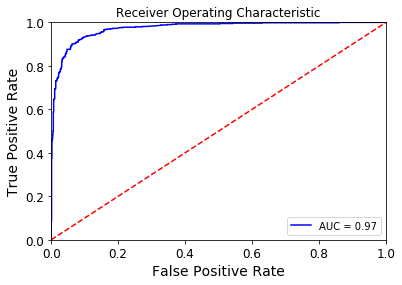

Saving figure Q3_13_ROC_curve_binary


<Figure size 432x288 with 0 Axes>

In [31]:
data = scipy.io.loadmat('spamData.mat')
Xtrain, Xtest, ytrain, ytest = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
logReg = LogisticRegression(preprocess="binarization", alpha=1)
logReg.fit(Xtrain, ytrain)
ytilde = logReg.transform(Xtest)
pestimate = logReg.decision(Xtest)
fpr, tpr, thresholds = roc_curve(ytest, pestimate, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
save_fig("Q3_13_ROC_curve_binary")

Saving figure Q3_14_precision_recall_vs_threshold_plot_binary


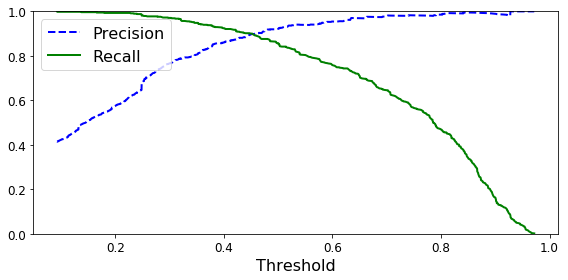

Optimal threshold is: 0.1497183151435035


In [32]:
precisions, recalls, thresholds = precision_recall_curve(ytest, pestimate)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.xlim([-60, -10])
save_fig("Q3_14_precision_recall_vs_threshold_plot_binary")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold is: " + str(optimal_threshold))

Saving figure Q3_15_precision_vs_recall_plot_binary


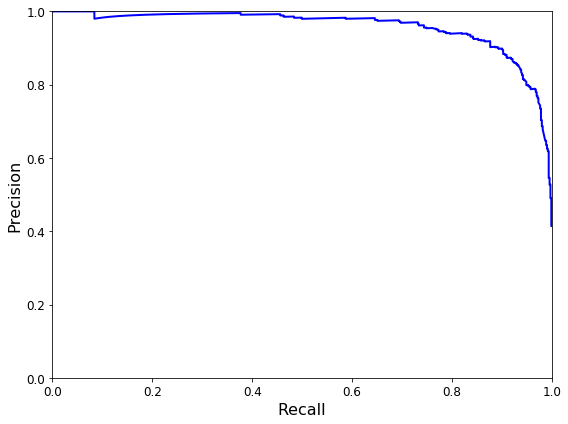

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("Q3_15_precision_vs_recall_plot_binary")
plt.show()